In [ ]:
# [예제 3-1] dropout 성능 확인하기

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활요하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0+cu113  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. MNIST 데이터 다운로드(Train set, Test set 분리하기) '''
train_dataset = datasets.MNIST(root = "./data/MNIST",
                              train = True,
                              download = True,
                              transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "./data/MNIST/",
                              train = False,
                              transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


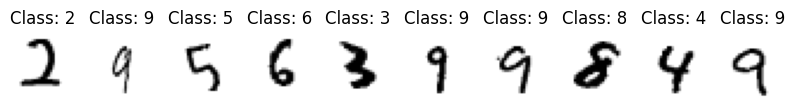

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train() # 모델을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE) # 기존 정의한 장비에 할당
        label = label.to(DEVICE) # 기존 정의한 장비에 할당
        optimizer.zero_grad() # 기존 할당되어 있던 gradient 값 초기화
        output = model(image) # Forward propagation
        loss = criterion(output, label) # loss 계산
        loss.backward() # Backpropagation을 통해 계산된 gradient 값을 각 파라미터에 할당
        optimizer.step() # 파라미터 업데이트
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                  Epoch, batch_idx * len(image),
                  len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                  loss.item()))

In [8]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval() # 모델을 평가 상태로 지정
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # 평가하는 단계에서 gradient를 통해 파라미터 값이 업데이트되는 현상을 방지
        for image, label in test_loader:
            image = image.to(DEVICE) # 기존 정의한 장비에 할당
            label = label.to(DEVICE) # 기존 정의한 장비에 할당
            output = model(image) # Forward propagation
            test_loss += criterion(output, label).item() # loss 누적
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item() 
            
    test_loss /= len(test_loader.dataset) # 평균 loss 계산
    test_accuracy = 100. * correct / len(test_loader.dataset) # 정확도 계산
    return test_loss, test_accuracy

In [9]:
class Net_with_dropout(nn.Module): # nn.Module 클래스 상속 -> 딥러닝 모델 관련 기본 함수를 포함
    def __init__(self): #  인스턴스 생성 시 지니게 되는 성질을 정의해주는 메서드
        super(Net_with_dropout, self).__init__() # nn.Module 내에 있는 매서드를 상속받아 이용
        self.fc1 = nn.Linear(28 * 28, 512) # 첫 번째 Fully Connected Layer 정의
        self.fc2 = nn.Linear(512, 256) # 두 번째 Fully Connected Layer 정의
        self.fc3 = nn.Linear(256, 10) # 세 번째 Fully Connected Layer 정의
        self.dropout_prob = 0.5
    def forward(self, x): # Forward Propagation 정의
        x = x.view(-1, 28 * 28) # 2차원 데이터를 1차원 데이터로 변환 -> MLP 모델은 1차원의 벡터 값을 입력으로 받을 수 있음
        x = self.fc1(x)
        x = F.sigmoid(x) # 활성화 함수
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1) # 확률 값 계산. log_softmax를 사용하는 이유는 gradient 값을 좀 더 원활하게 계산하기 위해 
        return x

model = Net_with_dropout().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Net_with_dropout(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.296960


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.289205
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 2.316490
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 2.314373
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 2.412419
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 2.303002
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 2.286214
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 2.340079
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 2.387946
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 2.256034

EPOCH: 1], 	Test Loss: 0.0711, 	Test Accuracy: 21.52 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 2.376101
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 2.266825
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 2.278690
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 2.291783
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 2.220051
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 2.315132
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 2.209401
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 2.285427
Train Epoch: 2 

In [10]:
# [예제 3-2] dropout + relu 성능 확인하기

In [11]:
class Net_with_dropout_relu(nn.Module): # nn.Module 클래스 상속 -> 딥러닝 모델 관련 기본 함수를 포함
    def __init__(self): #  인스턴스 생성 시 지니게 되는 성질을 정의해주는 메서드
        super(Net_with_dropout_relu, self).__init__() # nn.Module 내에 있는 매서드를 상속받아 이용
        self.fc1 = nn.Linear(28 * 28, 512) # 첫 번째 Fully Connected Layer 정의
        self.fc2 = nn.Linear(512, 256) # 두 번째 Fully Connected Layer 정의
        self.fc3 = nn.Linear(256, 10) # 세 번째 Fully Connected Layer 정의
        self.dropout_prob = 0.5
    def forward(self, x): # Forward Propagation 정의
        x = x.view(-1, 28 * 28) # 2차원 데이터를 1차원 데이터로 변환 -> MLP 모델은 1차원의 벡터 값을 입력으로 받을 수 있음
        x = self.fc1(x)
        x = F.relu(x) # 활성화 함수
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1) # 확률 값 계산. log_softmax를 사용하는 이유는 gradient 값을 좀 더 원활하게 계산하기 위해 
        return x
    
model = Net_with_dropout_relu().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Net_with_dropout_relu(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.314856
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.071999
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 1.242158
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.716584
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.603665
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.512974
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.442335
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.469546
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.573612
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.270458

EPOCH: 1], 	Test Loss: 0.0104, 	Test Accuracy: 90.49 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.433970
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.283557
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.323988
Train Epoch: 2 [19200/60000(32

In [12]:
# [예제 3-3] dropout + relu + Batch Normalization 성능 확인하기

In [13]:
class Net_with_dropout_relu_BN(nn.Module): # nn.Module 클래스 상속 -> 딥러닝 모델 관련 기본 함수를 포함
    def __init__(self): #  인스턴스 생성 시 지니게 되는 성질을 정의해주는 메서드
        super(Net_with_dropout_relu_BN, self).__init__() # nn.Module 내에 있는 매서드를 상속받아 이용
        self.fc1 = nn.Linear(28 * 28, 512) # 첫 번째 Fully Connected Layer 정의
        self.fc2 = nn.Linear(512, 256) # 두 번째 Fully Connected Layer 정의
        self.fc3 = nn.Linear(256, 10) # 세 번째 Fully Connected Layer 정의
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512) # 첫 번째 FC layer의 output 크기와 동일하게
        self.batch_norm2 = nn.BatchNorm1d(256) # 두 번째 FC layer의 output 크기와 동일하게
    def forward(self, x): # Forward Propagation 정의
        x = x.view(-1, 28 * 28) # 2차원 데이터를 1차원 데이터로 변환 -> MLP 모델은 1차원의 벡터 값을 입력으로 받을 수 있음
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) # 활성화 함수
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1) # 확률 값 계산. log_softmax를 사용하는 이유는 gradient 값을 좀 더 원활하게 계산하기 위해 
        return x
    
model = Net_with_dropout_relu_BN().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Net_with_dropout_relu_BN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.435903
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.654234
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.729689
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.214407
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.340866
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.354225
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.434620
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.312786
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.233698
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.117500

EPOCH: 1], 	Test Loss: 0.0047, 	Test Accuracy:

In [14]:
# [예제 3-4] dropout + relu + Batch Normalization + He Uniform Initialization 성능 확인하기

In [15]:
class Net_with_dropout_relu_BN(nn.Module): # nn.Module 클래스 상속 -> 딥러닝 모델 관련 기본 함수를 포함
    def __init__(self): #  인스턴스 생성 시 지니게 되는 성질을 정의해주는 메서드
        super(Net_with_dropout_relu, self).__init__() # nn.Module 내에 있는 매서드를 상속받아 이용
        self.fc1 = nn.Linear(28 * 28, 512) # 첫 번째 Fully Connected Layer 정의
        self.fc2 = nn.Linear(512, 256) # 두 번째 Fully Connected Layer 정의
        self.fc3 = nn.Linear(256, 10) # 세 번째 Fully Connected Layer 정의
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512) # 첫 번째 FC layer의 output 크기와 동일하게
        self.batch_norm2 = nn.BatchNorm1d(256) # 두 번째 FC layer의 output 크기와 동일하게
    def forward(self, x): # Forward Propagation 정의
        x = x.view(-1, 28 * 28) # 2차원 데이터를 1차원 데이터로 변환 -> MLP 모델은 1차원의 벡터 값을 입력으로 받을 수 있음
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) # 활성화 함수
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1) # 확률 값 계산. log_softmax를 사용하는 이유는 gradient 값을 좀 더 원활하게 계산하기 위해 
        return x

import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear): # MLP 모델을 구성하고 있는 파라미터 중 nn.Linear에 해당하는 파라미터 값에 대해서만 지정
        init.kaiming_uniform(m.weight.data) # 파라미터 값 초기화

model = Net_with_dropout_relu().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Net_with_dropout_relu(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.794667


/tmp/ipykernel_27398/569612395.py:27: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data) # 파라미터 값 초기화


Train Epoch: 1 [6400/60000(11%)]	Train Loss: 1.041914
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.721174
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.514280
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.585400
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.579763
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.585719
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.473004
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.663243
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.513607

EPOCH: 1], 	Test Loss: 0.0080, 	Test Accuracy: 92.53 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.391760
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.430022
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.613833
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.392684
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.470594
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.489169
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.199942
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.701211
Train Epoch: 2 

In [16]:
# [예제 3-5] dropout + relu + Batch Normalization + He Uniform Initialization + Adam 성능 확인하기

In [17]:
class Net_with_dropout_relu_BN(nn.Module): # nn.Module 클래스 상속 -> 딥러닝 모델 관련 기본 함수를 포함
    def __init__(self): #  인스턴스 생성 시 지니게 되는 성질을 정의해주는 메서드
        super(Net_with_dropout_relu_BN, self).__init__() # nn.Module 내에 있는 매서드를 상속받아 이용
        self.fc1 = nn.Linear(28 * 28, 512) # 첫 번째 Fully Connected Layer 정의
        self.fc2 = nn.Linear(512, 256) # 두 번째 Fully Connected Layer 정의
        self.fc3 = nn.Linear(256, 10) # 세 번째 Fully Connected Layer 정의
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512) # 첫 번째 FC layer의 output 크기와 동일하게
        self.batch_norm2 = nn.BatchNorm1d(256) # 두 번째 FC layer의 output 크기와 동일하게
    def forward(self, x): # Forward Propagation 정의
        x = x.view(-1, 28 * 28) # 2차원 데이터를 1차원 데이터로 변환 -> MLP 모델은 1차원의 벡터 값을 입력으로 받을 수 있음
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) # 활성화 함수
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1) # 확률 값 계산. log_softmax를 사용하는 이유는 gradient 값을 좀 더 원활하게 계산하기 위해 
        return x

import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear): # MLP 모델을 구성하고 있는 파라미터 중 nn.Linear에 해당하는 파라미터 값에 대해서만 지정
        init.kaiming_uniform(m.weight.data) # 파라미터 값 초기화

model = Net_with_dropout_relu_BN().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Net_with_dropout_relu_BN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.994092


/tmp/ipykernel_27398/3987426498.py:27: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data) # 파라미터 값 초기화


Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.594844
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.335959
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.259938
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.413181
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.145232
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.137868
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.442964
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.324795
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.403449

EPOCH: 1], 	Test Loss: 0.0041, 	Test Accuracy: 96.01 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.272545
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.084270
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.138753
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.071402
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.156637
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.502050
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.347759
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.155971
Train Epoch: 2 